Setup the environment to use TensorFlow, Keras, and Dataset (GOPRO,Berkely segmentation dataset 500 (BSD500)) manipulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import tensorflow as tf
from tensorflow.keras import layers, models

# For motion blur
import cv2

# For data loading & augmentation
import tensorflow_datasets as tfds


2025-04-21 20:51:16.108806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 20:51:16.367309: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-21 20:51:16.432449: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-21 20:51:16.947055: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-21 20:51:19.147848: W tensorflow/compiler/tf2

In [26]:
from tensorflow.image import psnr, ssim

def evaluate_psnr_ssim(model, dataset, max_val=1.0):
    psnr_vals = []
    ssim_vals = []

    for noisy, clean in dataset:
        denoised = model.predict(noisy, verbose=0)
        for i in range(denoised.shape[0]):
            psnr_val = psnr(clean[i], denoised[i], max_val=max_val).numpy()
            ssim_val = ssim(clean[i], denoised[i], max_val=max_val).numpy()
            psnr_vals.append(psnr_val)
            ssim_vals.append(ssim_val)

    mean_psnr = sum(psnr_vals) / len(psnr_vals)
    mean_ssim = sum(ssim_vals) / len(ssim_vals)
    return mean_psnr, mean_ssim


In [2]:
import os
import numpy as np
from PIL import Image

def load_gopro_dataset(blur_dir, sharp_dir, image_size=(256, 256), limit=None):
    X_blur = []
    Y_sharp = []

    blur_images = sorted(os.listdir(blur_dir))[:limit]
    for img_name in blur_images:
        blur_path = os.path.join(blur_dir, img_name)
        sharp_path = os.path.join(sharp_dir, img_name)  # same filename assumed

        # Load and preprocess
        blur_img = Image.open(blur_path).convert('L').resize(image_size)
        sharp_img = Image.open(sharp_path).convert('L').resize(image_size)

        # Normalize and expand dims to (H, W, 1)
        blur_np = np.expand_dims(np.array(blur_img).astype('float32') / 255., axis=-1)
        sharp_np = np.expand_dims(np.array(sharp_img).astype('float32') / 255., axis=-1)


        # Ensure 3 channels
        if blur_np.ndim == 2:
            blur_np = np.expand_dims(blur_np, -1)
        if sharp_np.ndim == 2:
            sharp_np = np.expand_dims(sharp_np, -1)

        X_blur.append(blur_np)
        Y_sharp.append(sharp_np)

    return np.array(X_blur), np.array(Y_sharp)


In [3]:
def load_gopro_dataset_all(data_dir, image_size=(256, 256), limit_per_sequence=None):
    def load_split(split):
        X_total, Y_total = [], []
        split_path = os.path.join(data_dir, split)
        sequences = sorted(os.listdir(split_path))

        for seq in sequences:
            blur_dir = os.path.join(split_path, seq, "blur")
            sharp_dir = os.path.join(split_path, seq, "sharp")

            if os.path.exists(blur_dir) and os.path.exists(sharp_dir):
                print(f"Loading {split}/{seq}...")
                X_blur, Y_sharp = load_gopro_dataset(
                    blur_dir, sharp_dir,
                    image_size=image_size,
                    limit=limit_per_sequence
                )
                X_total.extend(X_blur)
                Y_total.extend(Y_sharp)

        return np.array(X_total), np.array(Y_total)

    X_train, Y_train = load_split("train")
    X_test, Y_test = load_split("test")
    return (X_train, Y_train), (X_test, Y_test)


In [4]:
def add_gaussian_noise(img_array, mean=0.0, std=0.05):
    noise = np.random.normal(mean, std, img_array.shape)
    noisy_img = img_array + noise
    return np.clip(noisy_img, 0., 1.)

In [5]:
def process_bsd500_gaussian_blur_noise(image_dir, image_size=(256, 256), limit=None, blur_radius=2.5, noise_std=0.05):
    X_clean = []
    X_noisy = []

    image_files = sorted(os.listdir(image_dir))[:limit]

    for fname in image_files:
        path = os.path.join(image_dir, fname)
        try:
            img = Image.open(path).convert('L').resize(image_size)

            # Original clean image
            clean_np = np.array(img).astype('float32') / 255.
            clean_np = np.expand_dims(clean_np, axis=-1)  # Add channel dim (H, W, 1)

            # Apply Gaussian blur
            blurred_img = img.filter(ImageFilter.GaussianBlur(radius=blur_radius))
            blurred_np = np.array(blurred_img).astype('float32') / 255.
            blurred_np = np.expand_dims(blurred_np, axis=-1)  # Add channel dim (H, W, 1)

            # Add Gaussian noise
            noisy_np = add_gaussian_noise(blurred_np, std=noise_std)

            X_clean.append(clean_np)
            X_noisy.append(noisy_np)
        except Exception as e:
            print(f"Error processing {path}: {e}")

    return np.array(X_noisy), np.array(X_clean)



In [6]:
import tensorflow as tf

def create_tf_dataset(X_input, X_target, batch_size=16, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X_input, X_target))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X_input))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [ ]:
"""from tensorflow.keras import layers, Model

def build_autoencoder_v2(input_shape=(256, 256, 1)):
    input_layer = layers.Input(shape=input_shape, name="NoisedImage")

    # Encoder
    x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(input_layer)  # 128x128
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)            # 64x64
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)           # 32x32

    # Latent space
    x = layers.Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(x)

    # Decoder
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)  # 64x64
    x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)  # 128x128
    x = layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation="relu", kernel_initializer="he_normal")(x)  # 256x256

    # Output
    output_layer = layers.Conv2D(1, kernel_size=1, strides=1, padding="same", activation='sigmoid', name="DenoisedImage")(x)

    return Model(inputs=input_layer, outputs=output_layer, name="AutoEncoderV2")
"""

In [23]:
from tensorflow.keras import layers, Model

def build_autoencoder_v2(input_shape=(256, 256, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)  # 128x128

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)  # 64x64

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)  # 32x32

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)  # 16x16

    # Bottleneck
    bn = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    bn = layers.Conv2D(1024, 3, activation='relu', padding='same')(bn)

    # Decoder
    u4 = layers.UpSampling2D((2, 2))(bn)
    u4 = layers.Concatenate()([u4, c4])
    c5 = layers.Conv2D(512, 3, activation='relu', padding='same')(u4)
    c5 = layers.Conv2D(512, 3, activation='relu', padding='same')(c5)

    u3 = layers.UpSampling2D((2, 2))(c5)
    u3 = layers.Concatenate()([u3, c3])
    c6 = layers.Conv2D(256, 3, activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(256, 3, activation='relu', padding='same')(c6)

    u2 = layers.UpSampling2D((2, 2))(c6)
    u2 = layers.Concatenate()([u2, c2])
    c7 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    c7 = layers.Conv2D(128, 3, activation='relu', padding='same')(c7)

    u1 = layers.UpSampling2D((2, 2))(c7)
    u1 = layers.Concatenate()([u1, c1])
    c8 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)
    c8 = layers.Conv2D(64, 3, activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(c8)

    return Model(inputs, outputs, name="DeepUNetAutoencoder")


In [8]:
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available:", gpus[0])
else:
    print("No GPU detected — training may be slow.")


GPU is available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1745268683.400884    1952 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745268683.979483    1952 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745268683.982988    1952 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [14]:
if __name__ == '__main__':
    # Load the dataset
    # Make sure to set the correct path to your dataset
    # The dataset should be structured as:
    # GoPro/
    # ├── train/
    # │   ├── sequence_1/
    # │   │   ├── blur/
    # |   |   ├── blur_gamma
    # │   │   └── sharp/
    # │   └── sequence_2/
    # │       ├── blur/
    # |       ├── blur_gamma
    # │       └── sharp/
    # └── test/
    #     ├── sequence_1/
    #     │   ├── blur/
    #     |   ├── blur_gamma
    #     │   └── sharp/
    #     └── sequence_2/
    #         ├── blur/
    #         ├── blur_gamma
    #         └── sharp/


    # BSDS500/ 
    #       ├── images/
    #       │   │   ├── train/
    #       │   │   ├── test/
    #       │   │   └── val/
    #       │   └── groundTruth/
    #       │       ├── train/
    #       │       ├── test/
    #       │       └── val/


    # === GoPro Dataset ===
    data_path = "../../../GOPRO"  # adjust as needed
    (X_train_gopro, Y_train_gopro), (X_test_gopro, Y_test_gopro) = load_gopro_dataset_all(
        data_dir=data_path,
        image_size=(256, 256),
        limit_per_sequence=200
    )
    print("GoPro train:", X_train_gopro.shape, Y_train_gopro.shape)
    print("GoPro test:", X_test_gopro.shape, Y_test_gopro.shape)

    test_dataset_gopro = create_tf_dataset(X_test_gopro, Y_test_gopro, batch_size=16, shuffle=False)

    from sklearn.model_selection import train_test_split

    # Split 10% of training into validation set
    X_train, X_val, Y_train, Y_val = train_test_split(
        X_train_gopro, Y_train_gopro, test_size=0.1, random_state=42
    )

    # === BSD500 Dataset ===
    bsd_path = "../../../BSD500/images/train"  # update this to your extracted BSD path

    X_bsd_blur, X_bsd_clean = process_bsd500_gaussian_blur_noise(
        image_dir=bsd_path,
        image_size=(256, 256),
        limit=200,
        blur_radius=2.5,
        noise_std=0.05
    )
    print("BSD500 processed:", X_bsd_blur.shape, X_bsd_clean.shape)

    # === Convert BSD to tf.data.Dataset ===
    bsd_dataset = create_tf_dataset(X_bsd_blur, X_bsd_clean, batch_size=16)

    #show a batch
    for noisy, clean in bsd_dataset.take(1):
        print("Batch sample shapes:", noisy.shape, clean.shape)
    

    # Combine BSD500 + GoPro training data
    X_combined = np.concatenate([X_bsd_blur, X_train], axis=0)
    Y_combined = np.concatenate([X_bsd_clean, Y_train], axis=0)

    print("Combined training dataset shape:", X_combined.shape)
    print("→ From BSD500:", X_bsd_blur.shape[0])
    print("→ From GoPro:", X_train.shape[0])


    # === BSD500 Validation ===
    bsd_val_path = "../../../BSD500/images/val"
    X_val_bsd_blur, X_val_bsd_clean = process_bsd500_gaussian_blur_noise(
        image_dir=bsd_val_path,
        image_size=(256, 256),
        limit=None,
        blur_radius=2.5,
        noise_std=0.05
    )
    val_dataset_bsd = create_tf_dataset(X_val_bsd_blur, X_val_bsd_clean, batch_size=16, shuffle=False)

    bsd_test_path = "../../../BSD500/images/test"
    X_test_bsd_blur, X_test_bsd_clean = process_bsd500_gaussian_blur_noise(
        image_dir=bsd_test_path,
        image_size=(256, 256),
        limit=None,
        blur_radius=2.5,
        noise_std=0.05
    )
    test_dataset_bsd = create_tf_dataset(X_test_bsd_blur, X_test_bsd_clean, batch_size=16, shuffle=False)

    train_dataset = create_tf_dataset(X_combined, Y_combined, batch_size=16)
    val_dataset   = create_tf_dataset(X_val, Y_val, batch_size=16, shuffle=False)



Loading train/GOPR0372_07_00...


Loading train/GOPR0372_07_01...
Loading train/GOPR0374_11_00...
Loading train/GOPR0374_11_01...
Loading train/GOPR0374_11_02...
Loading train/GOPR0374_11_03...
Loading train/GOPR0378_13_00...
Loading train/GOPR0379_11_00...
Loading train/GOPR0380_11_00...
Loading train/GOPR0384_11_01...
Loading train/GOPR0384_11_02...
Loading train/GOPR0384_11_03...
Loading train/GOPR0384_11_04...
Loading train/GOPR0385_11_00...
Loading train/GOPR0386_11_00...
Loading train/GOPR0477_11_00...
Loading train/GOPR0857_11_00...
Loading train/GOPR0868_11_01...
Loading train/GOPR0868_11_02...
Loading train/GOPR0871_11_01...
Loading train/GOPR0881_11_00...
Loading train/GOPR0884_11_00...
Loading test/GOPR0384_11_00...
Loading test/GOPR0384_11_05...
Loading test/GOPR0385_11_01...
Loading test/GOPR0396_11_00...
Loading test/GOPR0410_11_00...
Loading test/GOPR0854_11_00...
Loading test/GOPR0862_11_00...
Loading test/GOPR0868_11_00...
Loading test/GOPR0869_11_00...
Loading test/GOPR0871_11_00...
Loading test/GOPR0

2025-04-21 21:09:20.379962: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1096810496 exceeds 10% of free system memory.
2025-04-21 21:09:21.499369: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 548405248 exceeds 10% of free system memory.


In [24]:
# === Build and compile model ===
autoencoder = build_autoencoder_v2(input_shape=(256, 256, 1))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

train_losses = []
val_losses_gopro = []
val_losses_bsd = []

EPOCHS = 20

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # 1. Train for 1 epoch
    history = autoencoder.fit(train_dataset, validation_data=val_dataset, epochs=1, verbose=1)

    # 2. Save training + GoPro val loss
    train_losses.append(history.history['loss'][0])
    val_losses_gopro.append(history.history['val_loss'][0])

    # 3. Evaluate on BSD500 val set
    val_loss_bsd = autoencoder.evaluate(val_dataset_bsd, verbose=0)
    val_losses_bsd.append(val_loss_bsd)



Epoch 1/20


2025-04-21 21:24:24.014070: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 25.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-21 21:24:36.873746: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.80GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-21 21:24:40.859805: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.6488

2025-04-21 21:25:24.186794: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.96GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
E0000 00:00:1745270724.891116    2003 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745270725.089954    2003 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-04-21 21:25:26.070904: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more m

131/131 ━━━━━━━━━━━━━━━━━━━━ 97s 470ms/step - loss: 0.6482 - val_loss: 0.5733

Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 239ms/step - loss: 0.5674 - val_loss: 0.5725

Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 239ms/step - loss: 0.5675 - val_loss: 0.5723

Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 240ms/step - loss: 0.5674 - val_loss: 0.5722

Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 240ms/step - loss: 0.5677 - val_loss: 0.5717

Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 240ms/step - loss: 0.5689 - val_loss: 0.5716

Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 240ms/step - loss: 0.5672 - val_loss: 0.5717

Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 240ms/step - loss: 0.5666 - val_loss: 0.5716

Epoch 9/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 240ms/step - loss: 0.5686 - val_loss: 0.5714

Epoch 10/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 240ms/step - loss: 0.5681 - val_loss: 0.5713

Epoch 11/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 240ms/step - loss: 0.5666 - val_loss: 0.5713

Epoch 12/20
131/131

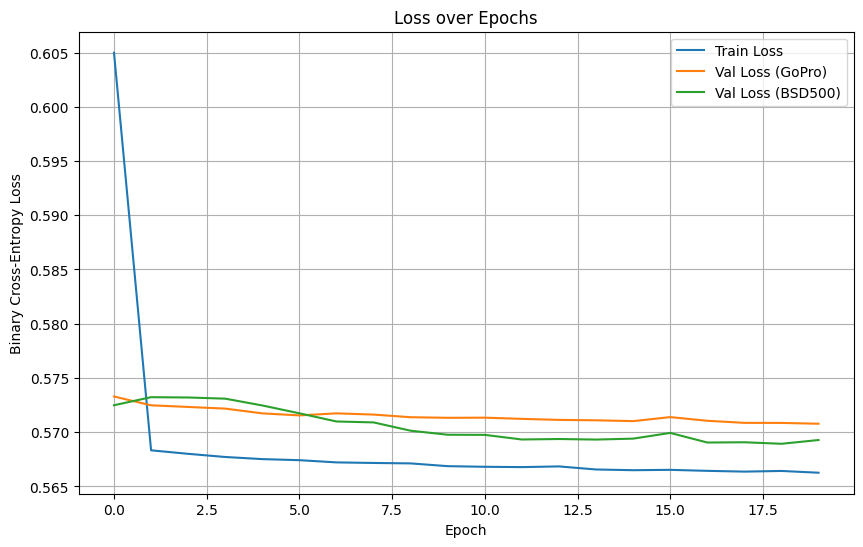

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses_gopro, label="Val Loss (GoPro)")
plt.plot(val_losses_bsd, label="Val Loss (BSD500)")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()



In [27]:
# === Evaluate PSNR and SSIM on test datasets ===
psnr_gopro, ssim_gopro = evaluate_psnr_ssim(autoencoder, test_dataset_gopro)
psnr_bsd, ssim_bsd = evaluate_psnr_ssim(autoencoder, test_dataset_bsd)

print(f"📷 PSNR (GoPro): {psnr_gopro:.2f}, SSIM (GoPro): {ssim_gopro:.4f}")
print(f"📷 PSNR (BSD500): {psnr_bsd:.2f}, SSIM (BSD500): {ssim_bsd:.4f}")



# === Evaluate on test sets ===
print("Test on GoPro:")
autoencoder.evaluate(test_dataset_gopro)

print("Test on BSD500:")
autoencoder.evaluate(test_dataset_bsd)


W0000 00:00:1745271723.749156    1952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745271723.765572    1952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745271723.766119    1952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745271723.766531    1952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745271723.768806    1952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745271723.782873    1952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745271723.784833    1952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745271723.785253    1952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745271723.785712    1952 gp

📷 PSNR (GoPro): 28.96, SSIM (GoPro): 0.8790
📷 PSNR (BSD500): 24.11, SSIM (BSD500): 0.6105
Test on GoPro:
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.5781
Test on BSD500:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.5829


0.5725372433662415

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


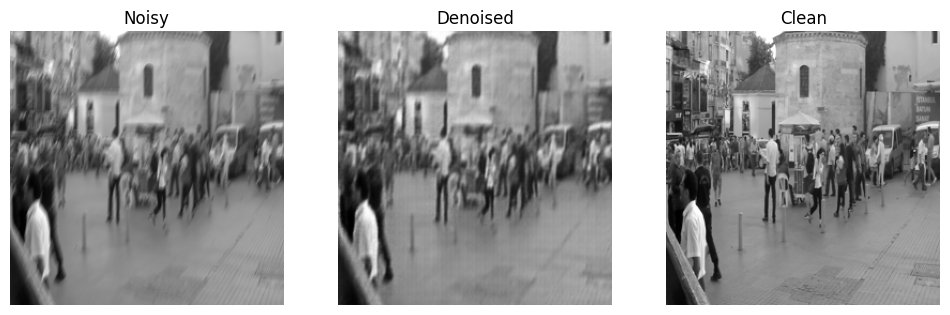

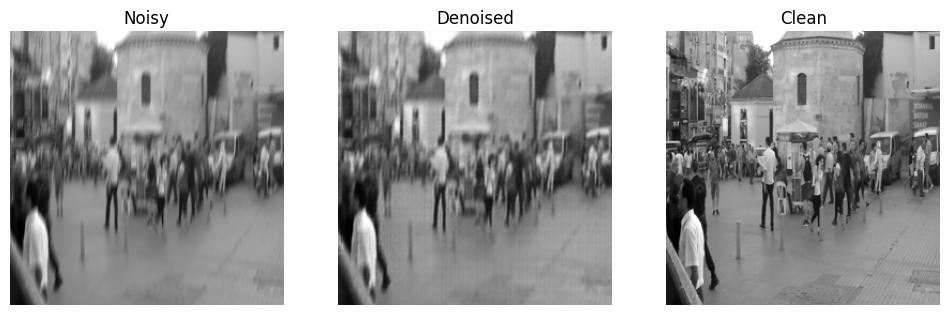

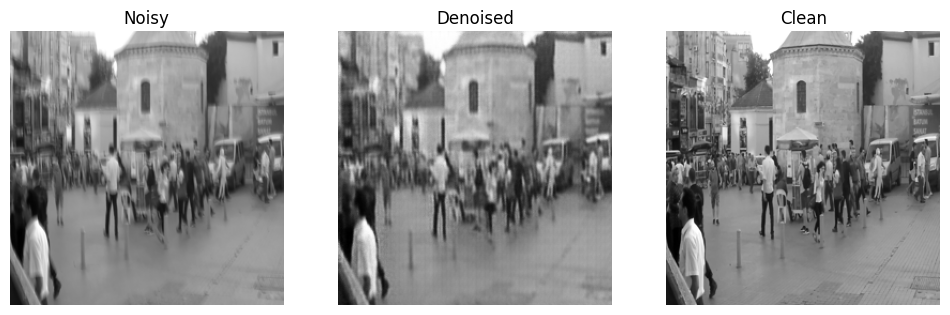

2025-04-21 21:21:12.204634: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
# === Visualize a few test results ===
import matplotlib.pyplot as plt

for noisy, clean in test_dataset_gopro.take(1):
    pred = autoencoder.predict(noisy)

    for i in range(3):  # show 3 examples
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Noisy")
        plt.imshow(noisy[i].numpy().squeeze(), cmap='gray')
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Denoised")
        plt.imshow(pred[i].squeeze(), cmap='gray')
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Clean")
        plt.imshow(clean[i].numpy().squeeze(), cmap='gray')
        plt.axis("off")
        plt.show()
